In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import nltk
from helper_functions import read_json_
from config import PATHES
from collections import Counter
import json



#from readability import Readability

# Ensuring NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/erikrubinov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikrubinov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erikrubinov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

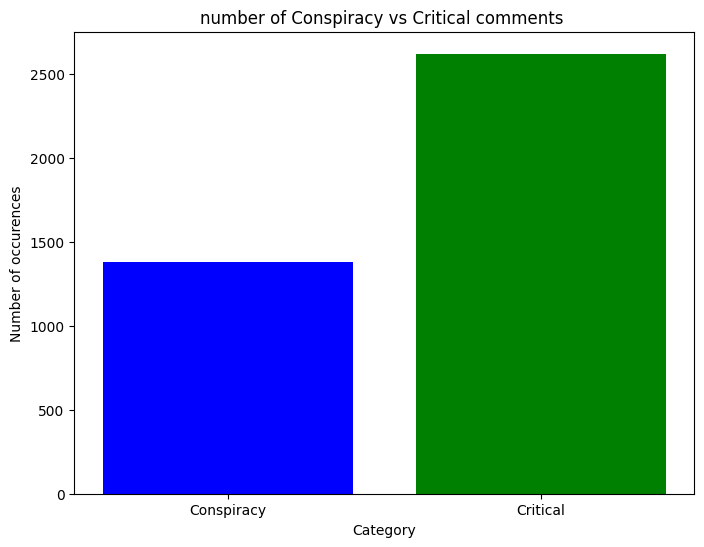

In [2]:
data = json.loads(open("Oppositional_thinking_analysis_dataset.json").read())


CONSPIRACY_counter = 0
CRITICAL_counter = 0

for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_counter+=1
    else:
        CRITICAL_counter+=1

categories = ['Conspiracy', 'Critical']
slur_counts = [CONSPIRACY_counter, CRITICAL_counter]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, slur_counts, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('Number of occurences')
plt.title('number of Conspiracy vs Critical comments ')
plt.show()

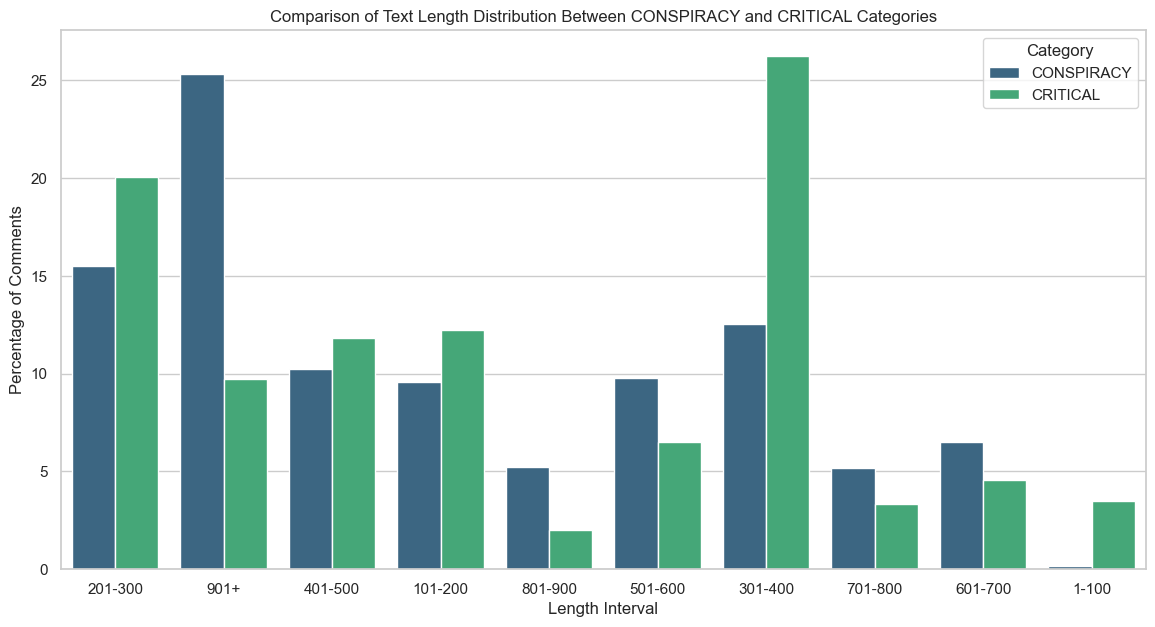

In [3]:


# Function to categorize the length into intervals
def categorize_length(length):
    if length <= 100:
        return '1-100'
    elif length <= 200:
        return '101-200'
    elif length <= 300:
        return '201-300'
    elif length <= 400:
        return '301-400'
    elif length <= 500:
        return '401-500'
    elif length <= 600:
        return '501-600'
    elif length <= 700:
        return '601-700'  # Adjusted interval correction
    elif length <= 800:
        return '701-800'
    elif length <= 900:
        return '801-900'
    else:
        return '901+'  # Adjusted to correctly include all longer comments

# Read JSON data
data = json.loads(open("Oppositional_thinking_analysis_dataset.json").read())

CONSPIRACY = []
CRITICAL = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY.append(len(comment["text"]))
    else:
        CRITICAL.append(len(comment["text"]))

# Count occurrences in specified intervals
occurrences_CONSPIRACY = Counter([categorize_length(length) for length in CONSPIRACY])
occurrences_CRITICAL = Counter([categorize_length(length) for length in CRITICAL])

# Data preparation for plotting
results = []
categories = ['CONSPIRACY', 'CRITICAL']
for category, occurrences in zip(categories, [occurrences_CONSPIRACY, occurrences_CRITICAL]):
    total = sum(occurrences.values())
    for length_interval, count in occurrences.items():
        results.append({
            'Category': category,
            'Interval': length_interval,
            'Percentage': (count / total) * 100
        })

df = pd.DataFrame(results)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.barplot(x='Interval', y='Percentage', hue='Category', data=df, palette='viridis')

plt.title('Comparison of Text Length Distribution Between CONSPIRACY and CRITICAL Categories')
plt.xlabel('Length Interval')
plt.ylabel('Percentage of Comments')
plt.legend(title='Category')

plt.show()

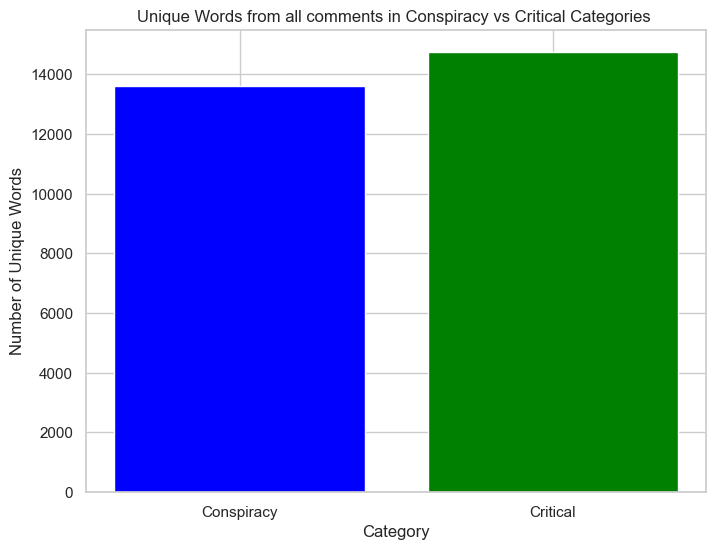

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


def get_vocabulary_richness(text:str) -> int:

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return (lemmatized_tokens)


CONSPIRACY = []
CRITICAL = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY = CONSPIRACY + get_vocabulary_richness(comment["text"])
    else:
        CRITICAL = CRITICAL + get_vocabulary_richness(comment["text"])
unique_words_CONSPIRACY = set(CONSPIRACY) 
unique_words_CRITICAL = set(CRITICAL) 

categories = ['Conspiracy', 'Critical']
unique_words_counts = [len(unique_words_CONSPIRACY), len(unique_words_CRITICAL)]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, unique_words_counts, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('Number of Unique Words')
plt.title('Unique Words from all comments in Conspiracy vs Critical Categories ')
plt.show()

['Conspiracy', 'Critical'] [0.8999274836838289, 0.9061426936283861]


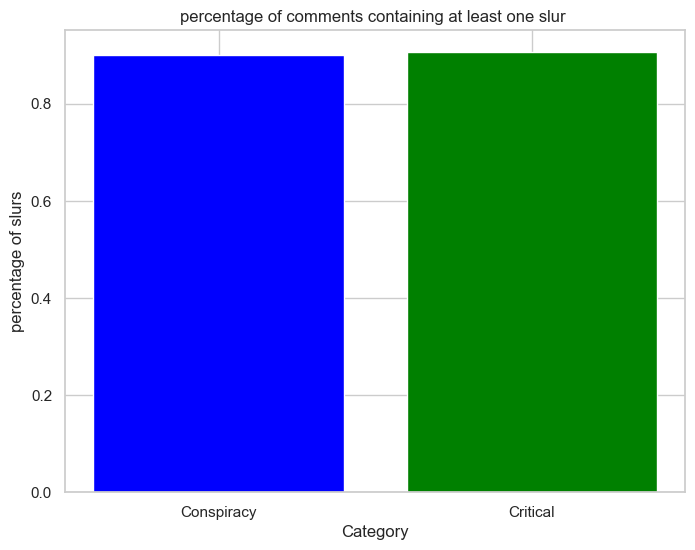

In [5]:
data = json.loads(open("Oppositional_thinking_analysis_dataset.json").read())
bad_words = json.loads(open("bad_words.json").read())
CONSPIRACY_bad_word_counter = 0
CRITICAL_bad_word_counter = 0
CONSPIRACY = []
CRITICAL = []

for comment in data:
    found_bad_word = False  
    for bad_word in bad_words:
        if bad_word in comment["text"]:
            if not found_bad_word: 
                found_bad_word = True  
                if comment["category"] == "CONSPIRACY":
                    CONSPIRACY_bad_word_counter += 1 
                else:
                    CRITICAL_bad_word_counter += 1  
            if comment["category"] == "CONSPIRACY":
                CONSPIRACY.append(bad_word)
            else:
                CRITICAL.append(bad_word)

categories = ['Conspiracy', 'Critical']
slur_counts = [CONSPIRACY_bad_word_counter/CONSPIRACY_counter, CRITICAL_bad_word_counter/CRITICAL_counter]

print(categories, slur_counts)
# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, slur_counts, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('percentage of slurs')
plt.title('percentage of comments containing at least one slur ')
plt.show()

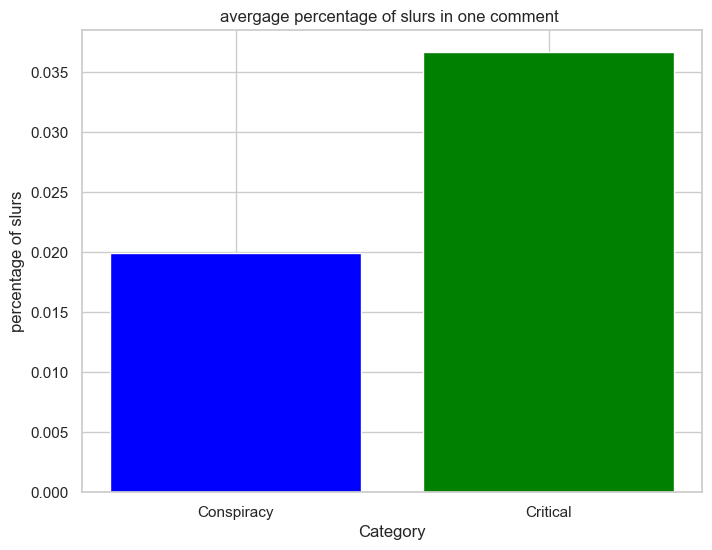

In [6]:
data = json.loads(open("Oppositional_thinking_analysis_dataset.json").read())
bad_words = json.loads(open("bad_words.json").read())
CONSPIRACY_avereage_bad_word_proportion_per_comment = []
CRITICAL_avereage_bad_word_proportion_per_comment = []


for comment in data:
    CONSPIRACY_badwords_per_comment = []
    CRITICAL_badwords_per_comment = []
    for bad_word in bad_words:
        if bad_word in comment["text"]:
            if comment["category"] == "CONSPIRACY":
                CONSPIRACY_badwords_per_comment.append(bad_word)
            else:
                CRITICAL_badwords_per_comment.append(bad_word)
    CONSPIRACY_avereage_bad_word_proportion_per_comment.append(len(CONSPIRACY_badwords_per_comment)/len(get_vocabulary_richness(comment["text"])))
    CRITICAL_avereage_bad_word_proportion_per_comment.append(len(CRITICAL_badwords_per_comment)/len(get_vocabulary_richness(comment["text"])))

categories = ['Conspiracy', 'Critical']

avereage_bad_word_proportion_per_comment_number= [np.mean(CONSPIRACY_avereage_bad_word_proportion_per_comment), np.mean(CRITICAL_avereage_bad_word_proportion_per_comment)]
# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, avereage_bad_word_proportion_per_comment_number, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('percentage of slurs')
plt.title('avergage percentage of slurs in one comment ')
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/erikrubinov/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


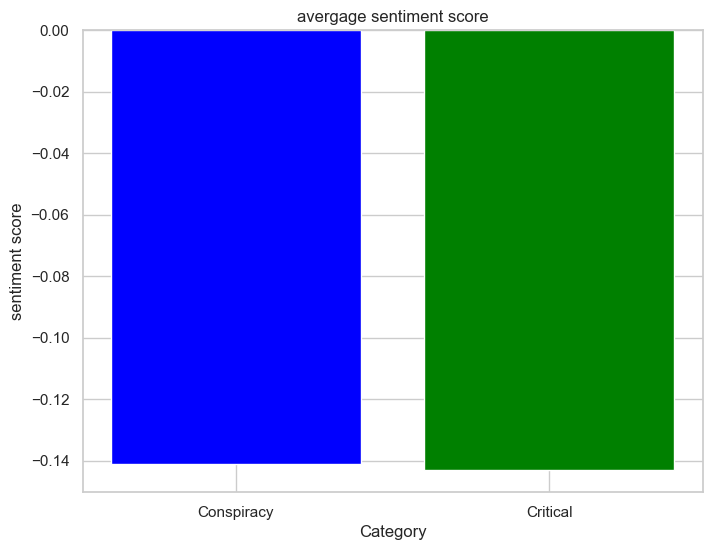

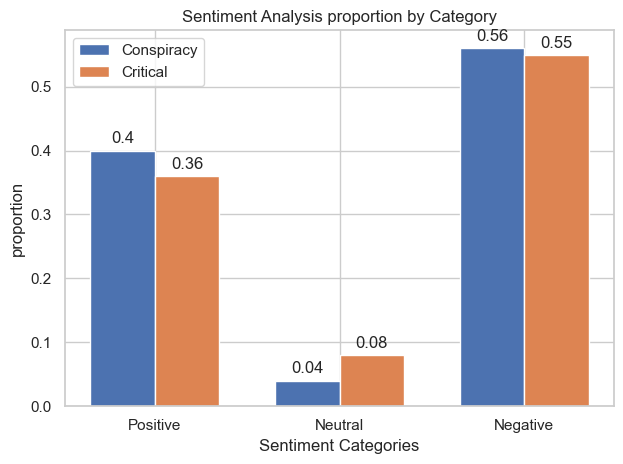

In [7]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

def analyze_sentiment(comment):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(comment)
    return sentiment

data = json.loads(open("Oppositional_thinking_analysis_dataset.json").read())
CONSPIRACY_sentiment_scores = []
CRITICAL_sentiment_scores = []


for comment in data:  
    sentiment = analyze_sentiment(comment["text"])["compound"] 
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_sentiment_scores.append(sentiment)
    else:
        CRITICAL_sentiment_scores.append(sentiment)

categories = ['Conspiracy', 'Critical']
sentiment_scores = [np.mean(CONSPIRACY_sentiment_scores), np.mean(CRITICAL_sentiment_scores)]

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, sentiment_scores, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('sentiment score')
plt.title('avergage sentiment score')
plt.show()


def categorize_sentiments(sentiment_scores):
    # Initialize a dictionary to hold the count of each sentiment category
    sentiment_counts = {'pos': 0, 'neutral': 0, 'neg': 0}

    # Iterate through each score in the input list
    for score in sentiment_scores:
        # Categorize the sentiment based on the compound score
        if score >= 0.05:
            sentiment_counts['pos'] += 1
        elif score <= -0.05:
            sentiment_counts['neg'] += 1
        else:
            sentiment_counts['neutral'] += 1

    return sentiment_counts


CONSPIRACY_sentiment_scores_categories = categorize_sentiments(CONSPIRACY_sentiment_scores)
CRITICAL_sentiment_scores_categories = categorize_sentiments(CRITICAL_sentiment_scores)

# Data setup
categories = ['Positive', 'Neutral', 'Negative']
conspiracy_counts = [round(CONSPIRACY_sentiment_scores_categories['pos']/CONSPIRACY_counter,2),round(CONSPIRACY_sentiment_scores_categories['neutral']/CONSPIRACY_counter,2), round(CONSPIRACY_sentiment_scores_categories['neg']/CONSPIRACY_counter,2)]
critical_counts = [round(CRITICAL_sentiment_scores_categories['pos']/CRITICAL_counter,2), round(CRITICAL_sentiment_scores_categories['neutral']/CRITICAL_counter,2), round(CRITICAL_sentiment_scores_categories['neg']/CRITICAL_counter,2)]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, conspiracy_counts, width, label='Conspiracy')
rects2 = ax.bar(x + width/2, critical_counts, width, label='Critical')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Sentiment Categories')
ax.set_ylabel('proportion')
ax.set_title('Sentiment Analysis proportion by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Function to add labels on the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Call the function to label the bars
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


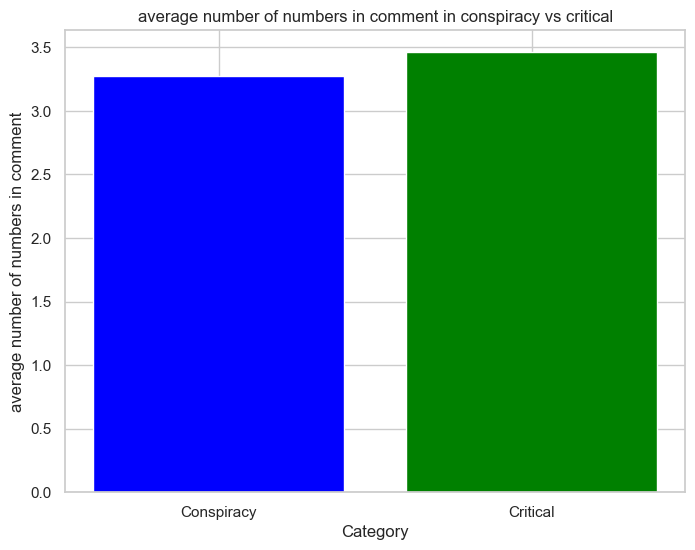

{}


In [19]:
import re

def extract_numbers_with_decimals(text):   
    numbers = re.findall(r'\d+\.\d+|\d+', text)
    numbers = [float(num) if '.' in num else int(num) for num in numbers]
    return numbers

CONSPIRACY_decimals = []
CRITICAL_decimals = []

decimals = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_decimals.append(len(extract_numbers_with_decimals(comment["text"])))
    else:
        CRITICAL_decimals.append(len(extract_numbers_with_decimals(comment["text"])))


categories = ['Conspiracy', 'Critical']

avereage_bad_word_proportion_per_comment_number= [np.mean(CONSPIRACY_decimals), np.mean(CRITICAL_decimals)]
# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, avereage_bad_word_proportion_per_comment_number, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('average number of numbers in comment')
plt.title('average number of numbers in comment in conspiracy vs critical')
plt.show()
    



In [27]:
from collections import Counter

CONSPIRACY_decimals = []
CRITICAL_decimals = []

decimals = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_decimals += (extract_numbers_with_decimals(comment["text"]))
    else:
        CRITICAL_decimals += (extract_numbers_with_decimals(comment["text"]))

CONSPIRACY_counter = Counter(CONSPIRACY_decimals)
CONSPIRACY_number_counts = dict(CONSPIRACY_counter)
CONSPIRACY_number_counts = {k: v for k, v in sorted(CONSPIRACY_number_counts.items(), key=lambda item: item[1])}

CRITICAL_counter = Counter(CRITICAL_decimals)
CRITICAL_number_counts = dict(CRITICAL_counter)
CRITICAL_number_counts = {k: v for k, v in sorted(CRITICAL_number_counts.items(), key=lambda item: item[1])}

# dictionary: key (number) value: number of its occurence
# dict is sorted by the number of occurences
print(CONSPIRACY_number_counts)
print(CRITICAL_number_counts)

{1.7: 1, 40525569: 1, 9779559: 1, 28606: 1, 1670304968950022144: 1, 360089: 1, 136641: 1, 1503452541450870787: 1, 1957: 1, 9368: 1, 17330: 1, 8299317: 1, 1408109674436567049: 1, 682: 1, 207: 1, 1525: 1, 1562: 1, 134922: 1, 18328: 1, 54817: 1, 38652: 1, 54001: 1, 0.1: 1, 0.3: 1, 1.3: 1, 115: 1, 206: 1, 3.4: 1, 3.6: 1, 3.8: 1, 4.4: 1, 4.6: 1, 6.2: 1, 12143935: 1, 9416347: 1, 99999: 1, 1376894411028770816: 1, 18953: 1, 25.1: 1, 11017119: 1, 545: 1, 2100: 1, 1116502: 1, 465: 1, 565018: 1, 1919: 1, 517: 1, 11635264333: 1, 121: 1, 49: 1, 569: 1, 356: 1, 253: 1, 57: 1, 257: 1, 604: 1, 1995: 1, 374: 1, 376: 1, 602: 1, 541: 1, 618: 1, 620: 1, 621: 1, 623: 1, 644: 1, 645: 1, 701: 1, 702: 1, 718: 1, 719: 1, 717: 1, 677: 1, 596: 1, 628: 1, 1206574413523476480: 1, 77962970: 1, 80132944: 1, 1961: 1, 8630821: 1, 18141: 1, 1069000436756172800: 1, 11005783: 1, 48266: 1, 700: 1, 777: 1, 14254: 1, 386: 1, 212: 1, 10536697: 1, 32000: 1, 1572855465272279042: 1, 1891: 1, 32467: 1, 77: 1, 48704213: 1, 104113

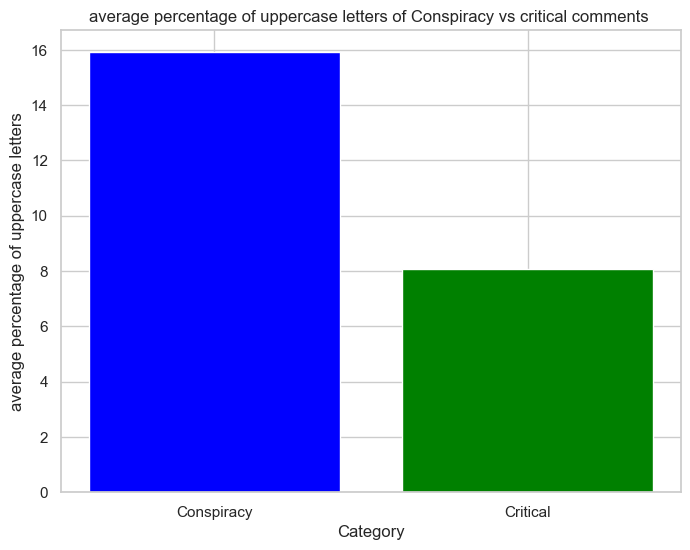

In [16]:
def calculate_uppercase_percentage(text):
    # Initialize counters for uppercase letters and total letters
    uppercase_count = 0
    total_letters = 0
    
    # Loop through each character in the text
    for char in text:
        if char.isalpha():  # Check if the character is a letter
            total_letters += 1
            if char.isupper():  # Check if the letter is uppercase
                uppercase_count += 1
    
    # Calculate the percentage of uppercase letters
    if total_letters == 0:
        return 0
    uppercase_percentage = (uppercase_count / total_letters) * 100
    
    return uppercase_percentage


CONSPIRACY_uppercase_letters = []
CRITICAL_uppercase_letters = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_uppercase_letters.append(calculate_uppercase_percentage(comment["text"]))
    else:
        CRITICAL_uppercase_letters.append(calculate_uppercase_percentage(comment["text"]))

categories = ['Conspiracy', 'Critical']

avereage_bad_word_proportion_per_comment_number= [np.mean(CONSPIRACY_uppercase_letters), np.mean(CRITICAL_uppercase_letters)]
# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, avereage_bad_word_proportion_per_comment_number, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('average percentage of uppercase letters')
plt.title('average percentage of uppercase letters of Conspiracy vs critical comments ')
plt.show()

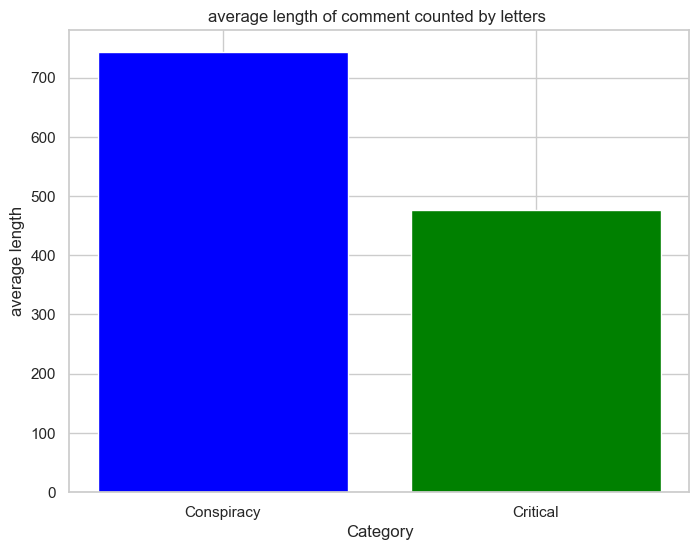

In [17]:
CONSPIRACY_length = []
CRITICAL_length = []
for comment in data:
    if comment["category"] == "CONSPIRACY":
        CONSPIRACY_length.append(len(comment["text"]))
    else:
        CRITICAL_length.append(len(comment["text"]))

categories = ['Conspiracy', 'Critical']

avereage_bad_word_proportion_per_comment_number= [np.mean(CONSPIRACY_length), np.mean(CRITICAL_length)]
# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(categories, avereage_bad_word_proportion_per_comment_number, color=['blue', 'green'])
plt.xlabel('Category')
plt.ylabel('average length')
plt.title('average length of comment counted by letters ')
plt.show()